### web crawling
- 1. requests : json : 동적페이지(URL 변경 없이 데이터를 수정 및 추가)
- 2. requests : html : 정적페이지(URL 변경으로 데이터를 수정 및 추가)
- 3. selenium : web browser : 1, 2번 방법을 사용하지 못할때 사용

# Guide
- 모바일 화면으로 하지 않는다. 
    - 만약 비동기 요청 처리하는 것 하려면 모바일 화면으로 한다.
    - 모바일 화면으로 할 때는 환율은 하지 않는다. 
- PC 화면은 동기적 요청 방식이다.
    - iframe을 썼기 때문에 딱 그 화면만 볼 수 있다.
        - iframe주소: https://finance.naver.com/marketindex/exchangeDailyQuote.nhn?marketindexCd=FX_USDKRW&page=1&pageSize=15
        - [원래주소](https://finance.naver.com/marketindex/exchangeDetail.nhn?marketindexCd=FX_USDKRW)
    - 환율도 로그인 하지 않아도 된다.

## TODO
- PC 화면 코드 작성요    

# Guide
- 동적 페이지에대한 설명 하고
1. 네이버 접속
2. 증권 메뉴 선택 - 복잡 => mobile 사이트로 이동 (Mobile이 있는 경우 같은 데이터가 간단하게 제공된다.)
    - url은 https://finance.naver.com/ 이다. 
    - https://finance.naver.com/sise/sise_index_day.nhn?code=KOSPI&page=5  이걸로 하면 동기적 요청으로 가져온다. (국내증시-코스피 클릭)
3. 구글에서 `네이버 증권 mobile` 로 검색 또는 **개발자 도구에서 화면을 작게 하고 증권 누르면 그쪽으로 이동한다.==>> GUIDE: 이거 잘안된다 그냥 구글검색**
    - https://m.stock.naver.com/
4. 국내/코스피 선택 -> 코스닥 선택하면 코스닥쪽 이다.
<img src='img/01_img.png' width='30%'>
5. 아래 일별 시세 나오는데 `더보기` 클릭하면 주소는 안바뀌는데(리로딩이 안되는데) 데이터는 바뀐다
    - 동적 페이지
6. 개발자 도구에서 `네트워크` 탭 선택    
    - xhr로 Request url header 설명 (Get방식이고 등등)

### 1. 네이버 주식 데이터 크롤링

- 코스피 데이터 수집
- 코스닥 데이터 수집

- USD환율 데이터 수집 => GUIDE: 이건 하지 않는다.
    - 환율은 먼저 웹에서 네이버 로그인 한 다음에 환율 조회하여 나온 cookie를 보내야 한다. 
    - 원래 웹페이지도 로그인 하지 않으면 안나온다. (첫페이지는 클릭 url을 이용해 나오고 다음페이지 보기가 안나온다. 결국 로그인 해야 조회가 된다. 우씨...)
- 그래프 그리기
- 상관계수를 확인

#### 크롤링 절차
- 1. 웹서비스 분석 : URL 분석하기
- 2. request, response 하기 : json 얻기
- 3. 문자열 json 데이터를 dict로 변경(파싱) 후 데이터프레임으로 생성

In [1]:
import requests

In [24]:
# 1. 웹 서비스 분석 : URL
url = "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSPI&pageSize=1300&page=1"
# url = "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?code=KOSDAQ&pageSize=20&page=4" : 코스닥 -> 함수로 만들어 매개변수만 바꾸게 하면 된다. (코스닥 시킨 뒤에 이건 시키기)

In [25]:
# 2. request, response : JSON(str)
response = requests.get(url)
response

<Response [200]>

In [26]:
type(response.text)

str

In [27]:
# response.json()

In [28]:
# 3. str 데이터를 dict로 파싱 후 데이터 프레임으로 만들기
datas = response.json()["result"]["siseList"]
type(datas), len(datas)

(list, 1300)

In [34]:
import pandas as pd
kospi_df = pd.DataFrame(datas)
kospi_df.head(1)

cd        dt      ncv    cv    cr      ov       hv       lv
0  KOSPI  20200722  2228.66 -0.17 -0.01  2228.2  2238.86  2221.62

- ncv: 종가
- ov : 시가(시작가)
- hv: 장중 최고
- lv: 장중 최저
- cv: 전일대비
- cr: 등락률


#### TODO:  KOSDAQ 크롤링

In [24]:
# 1. 웹 페이지 분석 : URL
url = "https://m.stock.naver.com/api/json/sise/dailySiseIndexListJson.nhn?\
code=KOSDAQ&pageSize=20&page=1"

In [25]:
# 2. request, response : JSON
response = requests.get(url)
response

<Response [200]>

In [26]:
# 3. JSON(str) -> dict -> DataFrame
datas = response.json()["result"]["siseList"]
kosdaq_df = pd.DataFrame(datas)
kosdaq_df.tail(3)

cd    cr    cv        dt      hv      lv     ncv      ov
17  KOSDAQ  0.83  5.34  20191015  647.40  641.49  646.80  641.51
18  KOSDAQ  1.34  8.51  20191014  643.41  637.69  641.46  638.65
19  KOSDAQ -0.28 -1.78  20191011  638.49  632.92  632.95  638.22

#### USD 크롤링: 이거 하지마..쩝
- 시장지표 메뉴 선택
- 아래 더보기 => 네트워크탭
- GUIDE : 이거 로그인 후 cookie를 보내야 한다. (로그인 안하면 조회안된다.) 그래서 조회 안됨. (원래 그렇다.)
    - 처음 나오는 것은 주소창  url로 요청한 결과이고 그 다음 부터는 로그인 해야 가져 올 수 있다.

In [11]:
# 1. 웹 페이지 분석 : URL
url = "https://m.stock.naver.com/api/json/marketindex/marketIndexDay.nhn?marketIndexCd=FX_USDKRW&pageSize=20&page=1"
print(url)

https://m.stock.naver.com/api/json/marketindex/marketIndexDay.nhn?marketIndexCd=FX_USDKRW&pageSize=20&page=1


In [12]:
# 2. request, response : JSON
response = requests.get(url)

In [13]:
response.text
# GUIDE: 네이버에 로그인하고 받은 쿠키가 필요 하다. 흠
# 로그인 문제이므로 쿠키..
# 쿠키를 카피해 온다. 그런데 너무 많다. 그래서 cookie:전체 로 header 로 설정해 넘긴다. (어짜피 cookies 해도 header 로 넘어가므로)

'{"result":{"errorMessage":"로그인이 필요한 서비스 입니다.\\n로그인 하시겠습니까?","errorCode":"authenticationFail"},"resultCode":"error"}'

In [10]:
import requests
headers = {
    'cookie': 'NNB=67C4ISYJP7FF4; NRTK=ag#all_gr#1_ma#-2_si#0_en#0_sp#0; ASID=3b0e35fa00000172c74c621400000059; _fbp=fb.1.1592481734524.704641389; _ga=GA1.2.939167763.1593955597; nx_ssl=2; nid_inf=-1484952898; NID_AUT=g4SreK8n5GavLG6dITyI+2y5RoeOOeHwG7Twt4mwzFqR3L4xOp9Hm6o7OI1Cj7Va; NID_JKL=levb7B5PmeZ/Y5oMTuq/SHMciLlS4BidkLNVVrP+TzE=; nid_tct=zPA6bgH8sGUG45B3; NID_SES=AAABl/JoBN0SsDc8Fy53MHam2y+NGZJaRx4BSC4nYIJpOA19KA711Ypy+vITLSpsr0f/sUxMIc6yokH7lNp2MxRUjOo98FiBpxz7hOt62WpsxsPSJ4xXfbg0M+Jf5TbTmHp9div1TA6+OGWDZR2KPQQA8KaUSAKCqnLXNH0gBY9HlwYw82u1kudZ87rjTAh67/ZymgEF8fEqATzaiwR/NBeilyIKzOMpt932YKWeKYS/ThEXA6V0hUOSUB/7hEZfddN8nAa84oxqM6BXJowoCDpCg2bWHdoAAidxWeLqGEIvSqVmidZmCMGaY884yN6PCOQwLp8t0Vtye9NoLljS30lGY9XDzmpUvaLGJbXklL6zBk1SoZXFDJ1H5rjy8joRYoMEgXSy0e4RgH4mMYWcGJsCwTDv4zjZihucZWzllx5ZGF5B74qjzo3q6VeVuMCMCEG7EG04mhUYlQAhIWinGtAiH0qUDYBVfgKschUx+oCNsbK8hSdB6B0idIPngfgzLWl8M//gcbd3fvcltxZrBMdizMBemY4mR9pjjDJtS5hfDmtz; JSESSIONID=3CE5A6E0EE807737CBE51BCDD6F8ABC9; BMR=; XSRF-TOKEN=43046238-5a5f-4146-9dfa-0fb50e67bcca'
}
response = requests.get(url, headers=headers)
response.json()

{'result': {'errorMessage': '로그인이 필요한 서비스 입니다.\n로그인 하시겠습니까?',
  'errorCode': 'authenticationFail'},
 'resultCode': 'error'}

In [6]:
# 3. JSON(str) -> dict -> DataFrame
datas = response.json()["result"]["marketIndexDay"]
usd_df = pd.DataFrame(datas)
usd_df.head(10)

KeyError: 'marketIndexDay'

In [32]:
len(kospi_df), len(kosdaq_df), len(usd_df)

(20, 20, 20)

# 여기이후는
- 나중에 판다스하고 나서
#### 그래프로 그리기


In [35]:
%matplotlib inline

In [36]:
%config InlineBackend.figure_formats = {'png', 'retina'}

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

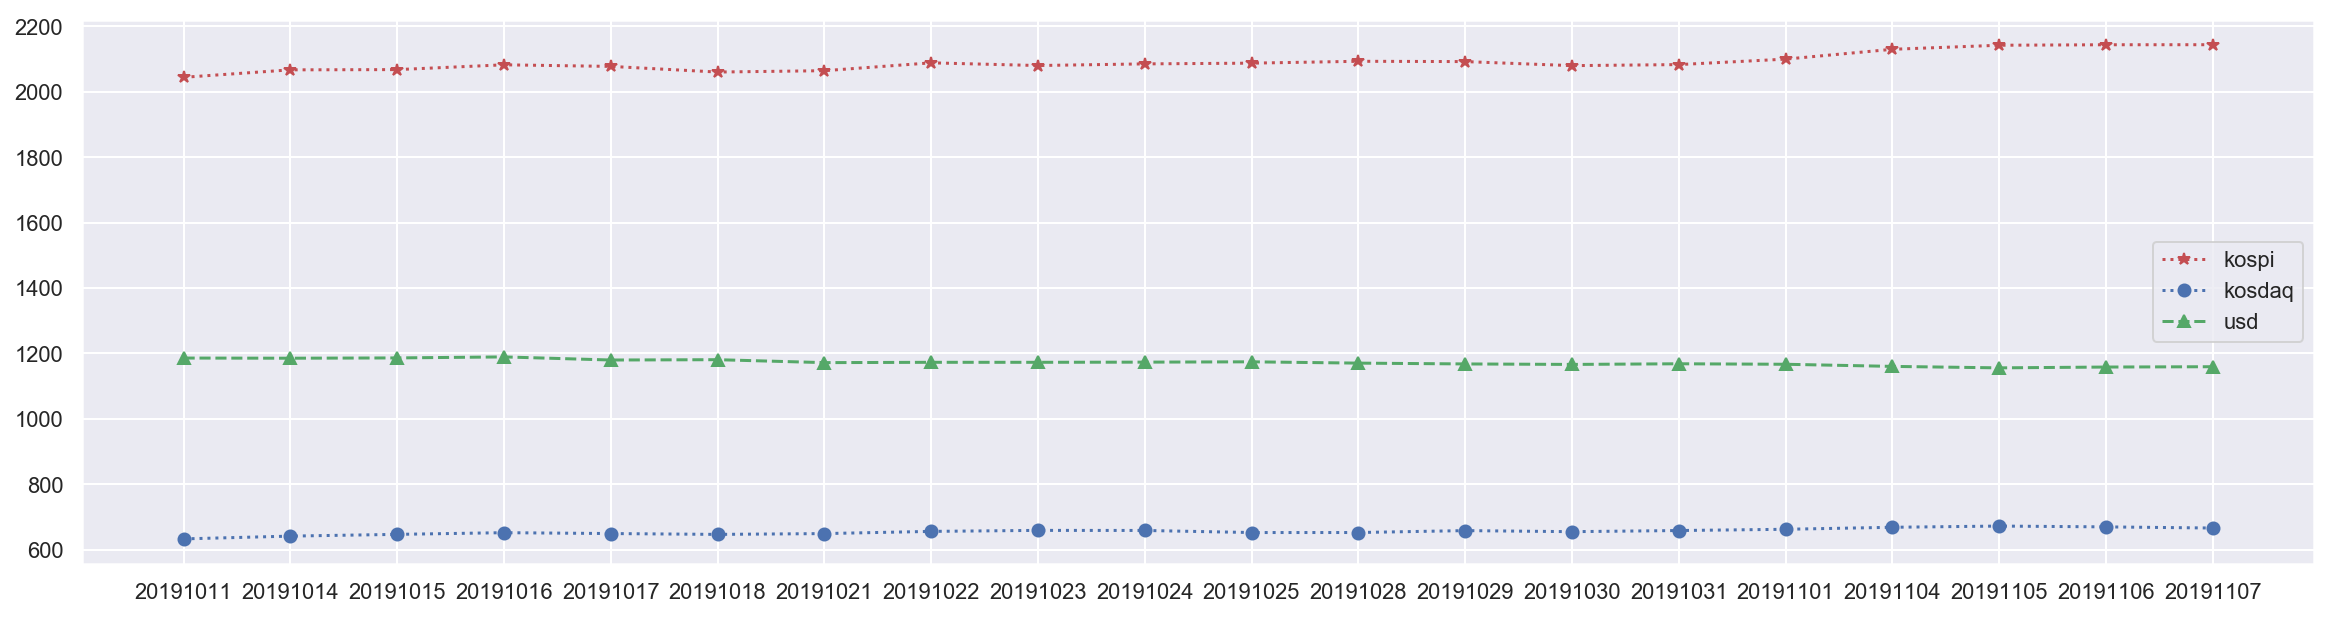

In [47]:
# 코스피, 코스닥, 환율 종가 데이터 그리기
plt.figure(figsize=(20, 5))

plt.plot(kospi_df[::-1]["dt"], kospi_df[::-1]["ncv"], "r*:", label="kospi")
plt.plot(kosdaq_df[::-1]["dt"], kosdaq_df[::-1]["ncv"], "bo:", label="kosdaq")
plt.plot(usd_df[::-1]["dt"], usd_df[::-1]["nv"], "g^--", label="usd")
plt.legend(loc=0)

plt.show()

In [45]:
usd_df.tail(1)

cbv    cr      csv   cv        dt      nv      rv      sv
19  1206.75 -0.75  1165.25 -9.0  20191011  1186.0  1174.4  1197.6

#### 정규화 : Nomalization
- `z = (x - min(x)) / (max(x) - min(x))`

In [48]:
from sklearn import preprocessing

In [49]:
preprocessing.minmax_scale(kospi_df[::-1]["ncv"])

array([0.        , 0.22863162, 0.23635634, 0.38342697, 0.33436998,
       0.16131621, 0.20294944, 0.44392055, 0.36125602, 0.41181782,
       0.43418941, 0.49147271, 0.4823435 , 0.35774478, 0.38994783,
       0.55768459, 0.85904896, 0.98344703, 0.99859551, 1.        ])

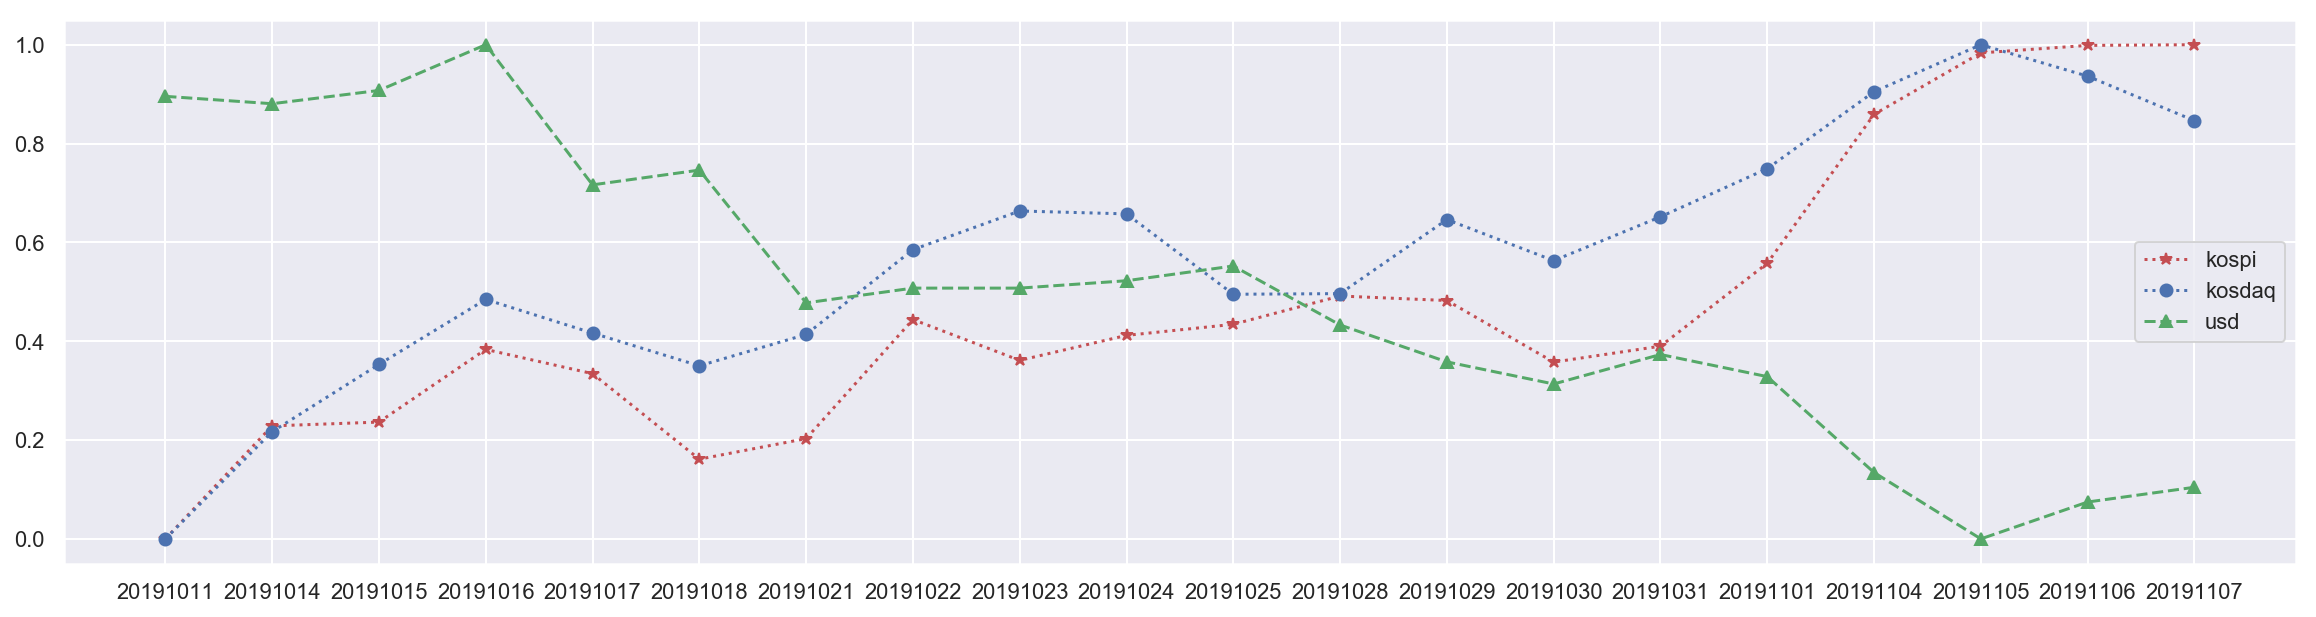

In [51]:
# 코스피, 코스닥, 환율 종가 데이터 그리기
plt.figure(figsize=(20, 5))

plt.plot(kospi_df[::-1]["dt"], 
         preprocessing.minmax_scale(kospi_df[::-1]["ncv"]), 
         "r*:", label="kospi")
plt.plot(kosdaq_df[::-1]["dt"], 
         preprocessing.minmax_scale(kosdaq_df[::-1]["ncv"]), 
         "bo:", label="kosdaq")
plt.plot(usd_df[::-1]["dt"], 
         preprocessing.minmax_scale(usd_df[::-1]["nv"]), 
         "g^--", label="usd")
plt.legend(loc=0)

plt.show()

In [52]:
import numpy as np

In [53]:
np.corrcoef(kospi_df["ncv"], kosdaq_df["ncv"])[0, 1]

0.9101026808848969

In [54]:
np.corrcoef(kospi_df["ncv"], usd_df["nv"])[0, 1]

-0.838926140662972

In [55]:
np.corrcoef(kosdaq_df["ncv"], usd_df["nv"])[0, 1]

-0.876222189145846